<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analysis & Numerical Optimization**

**Import Libraries & Data**

In [0]:
!pip install livelossplot --quiet

import tensorflow as tf
import datetime, os
from livelossplot import PlotLossesKeras

# Populating the interactive namespace from numpy and matplotlib
# %pylab inline
import numpy as np
from mpl_toolkits import mplot3d
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
import math 

print(tf.__version__)

2.2.0


In [0]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# **Differential Calculus**

Most if this part is from [here](https://github.com/xavierbourretsicotte/Data-Portfolio/blob/master/Intro_to_Optimization_Visualizations.ipynb) and [here](https://xavierbourretsicotte.github.io/Intro_optimization.html#Finding-extrema-of-a-function)

The following is a collection of sources of interest which were used to build this notebook:
- [Duke university: Optimization and Non-linear Methods][1]
- [Sebastien Ruder's blog][2]
- [Nonlinear Optimization course at the University of Jyväskylä][3]
- [Numerical python tours][4]
- [Louis Tiao's blog: visualizing-and-animating-optimization-algorithms-with-matplotlib][5]

[1]: https://people.duke.edu/~ccc14/sta-663/OptimizationInOneDimension.html
[2]: http://ruder.io/optimizing-gradient-descent/
[3]: https://github.com/maeehart/TIES483
[4]: http://www.numerical-tours.com/python/
[5]: http://tiao.io/notes/visualizing-and-animating-optimization-algorithms-with-matplotlib/


## **Finding roots of non linear functions (1D)**

**Example used throughout this section:**

Consider the following polynomial function which is continuous, differentiable and well behaved. It is an interesting example to use when testing root finding algorithms because it exhibits several *basins of attractions* in 1D. A basin of attraction is a set of initial values leading to the same solution (i.e. root in this case), see [here][1] for some details. In this example, different starting points will lead to different solutions, or in some cases no solutions at all when the algorithm "blows up"

The next section will investigate different methods of finding the **roots** of:

$f(x) = x^3 - 2x^2 - 11x + 12$

$f'(x) = 3x^2 - 4x - 11$

[1]: https://fr.mathworks.com/help/gads/what-is-global-optimization.html#bsbalkx-1

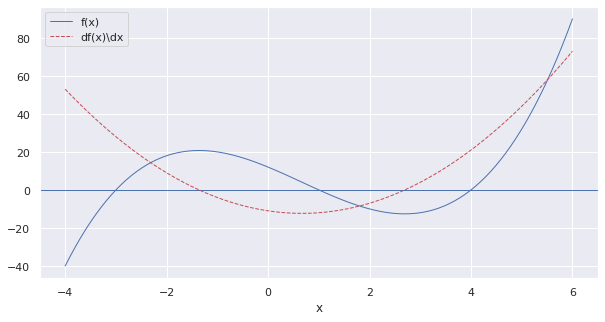

In [0]:
import seaborn as sns

sns.set(rc={'figure.figsize':(10, 5), "lines.linewidth": 1.0})

#Defining the functions and its first derivative
def f(x):
    return x**3 - 2*x**2 - 11*x + 12

def dfdx(x):
    return 3*x**2 - 4*x - 11
    
#Initializing data
x = np.linspace(-4,6,100)
y = f(x)
y_dash = dfdx(x)

#Plotting the function and its derivative
#fig = plt.figure()
plt.xlabel('x')
plt.axhline(0)
plt.plot(x,y, label = 'f(x)')
plt.plot(x,y_dash, '--r', label = 'df(x)\dx')
plt.legend()
plt.show()

**Bisection Method**

The bisection method is one of the simplest methods for finding zeroes of a non-linear function. It is guaranteed to find a root - but it can be slow. The main idea comes from the intermediate value theorem: If $f(a)$ and $f(b)$ have different signs and $f$ is continous, then f must have a zero between a and b. We evaluate the function at the midpoint, $c=\frac{1}{2}(a+b).$ $f(c)$ is either zero, has the same sign as f(a) or the same sign as $f(b)$. Suppose $f(c)$ has the same sign as f(a) (as pictured below). We then repeat the process on the interval $[c,b]$.

In [0]:
def Bisection_Search(func,a,b,epsilon,nMax = 1000):
    #Initializating variables, iter_x, iter_x are used to plot results
    i = 0
    iter_x, iter_y, iter_count = np.empty(0),np.empty(0),np.empty(0)
    
    #Looping condition to ensure that loop is not infinite
    while i < nMax:
        i +=1
        c = .5 *(a + b)
        
        iter_x = np.append(iter_x,c)
        iter_y = np.append(iter_y,func(c))
        iter_count = np.append(iter_count ,i)
        
        if np.abs(func(c)) < epsilon:
            return c, iter_x, iter_y, iter_count
        elif np.sign(func(c)) == np.sign(func(a)): 
            a = c
        elif np.sign(func(c)) == np.sign(func(b)): 
            b = c

root,iter_x,iter_y, iter_count = Bisection_Search(f,-5,-2,0.01)

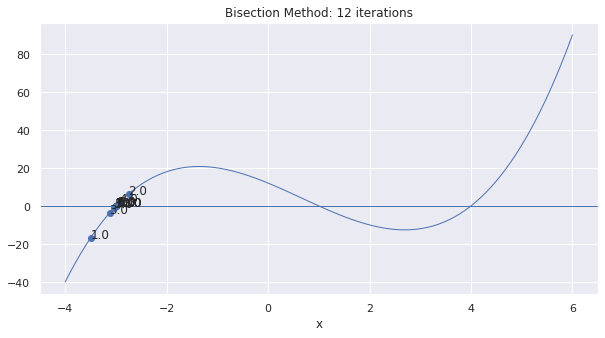

In [0]:
#Plotting the iterations and intermediate values
fig, ax = plt.subplots() 
ax.set_xlabel('x')
ax.axhline(0)
ax.plot(x,y)
ax.scatter(x = iter_x,y = iter_y)
ax.set_title('Bisection Method: {} iterations'.format(len(iter_count)))

#Loop to add text annotations to the iteration points
for i, txt in enumerate(iter_count):
    ax.annotate(txt, (iter_x[i], iter_y[i]))
    
plt.show()

**Newton Raphson's method**

Newton's method, also known as Newton-Raphson's method, is a very famous and widely used method for solving nonlinear algebraic equations. Compared to the other methods we will consider, it is generally the fastest one (usually by far). It does not guarantee that an existing solution will be found, however.

Newton's method is normally formulated with an iteration index n: 

$x_{n+1} = x_n - \large \frac{f(x_n)}{f'(x_n)}$

To avoid storing intermediate values in memory, one can overwrite the previous value and work with a single variable: 

$x := x - \frac{f(x)}{f'(x)}$

In this example:

$f(x) = x^3 - 2x^2 - 11x + 12$

$f'(x) = 3x^2 - 4x - 11$


In [0]:
def Newton_Raphson(func, deriv, x, epsilon, nMax = 100):
    #Initializating variables, iter_x, iter_x are used to plot results
    i = 0
    iter_x, iter_y, iter_count = np.empty(0),np.empty(0),np.empty(0)
    
    error = x - (x - func(x)/ deriv(x))
    
    #Looping as long as error is greater than epsilon
    while np.abs(error) > epsilon and i < nMax:
        i +=1
        iter_x = np.append(iter_x,x)
        iter_y = np.append(iter_y,func(x))
        iter_count = np.append(iter_count ,i)

        error = x - (x - func(x)/ deriv(x))
        x = x - func(x)/ deriv(x)
    
    
    return x, iter_x, iter_y, iter_count


root,iter_x,iter_y, iter_count = Newton_Raphson(f,dfdx,-2,0.01)

In [0]:
#Plotting the iterations and intermediate values
fig, ax = plt.subplots() 
ax.set_xlabel('x')
ax.axhline(0)
ax.plot(x,y)
ax.scatter(x = iter_x,y = iter_y)
ax.set_title('Newton Method: {} iterations'.format(len(iter_count)))

for i, txt in enumerate(iter_count):
    ax.annotate(txt, (iter_x[i], iter_y[i]))
    
plt.show()

In [0]:
# Newton Raphson's using Scipy
# Similar results are obtained using Scipy's built in optimizer

import scipy.optimize
scipy.optimize.newton(f,6,dfdx)

**Secant method**

When finding the derivative $f′(x)$ in Newton's method is problematic, or when function evaluations take too long; we may adjust the method slightly. Instead of using tangent lines to the graph we may use secants. The approach is referred to as the secant method. 

The idea of the secant method is to think as in Newton's method, but instead of using $f′(x_n)$, we approximate this derivative by a finite difference or the secant, i.e., the slope of the straight line that goes through the two most recent approximations $x_n$ and $x_n{−1}$. This slope reads

$f'(x_n) \approx \large \frac{f(x_n) - f(x_{n-1})}{x_n - x_{n-1}}$

Inserting this expression for $f'(x_n)$ into Newton's method simply gives us the secant method:

$x_{n+1} = x_n - f(x_n) \times \large \frac{x_n - x_{n-1}}{f(x_n) - f(x_{n-1})}$

As with the Bisection Search - the secant method requires *two* starting points

In [0]:
def Secant_method(func, x0,x1, epsilon, nMax = 100):
    #Initialization
    i = 0
    x2 = 0
    iter_x, iter_y, iter_count = np.empty(0),np.empty(0),np.empty(0)
    error = 100
    
    x2 = x1 - func(x1) * ((x1 - x0 ) / (func(x1) - func(x0))) 
    
    #Looping as long as error is greater than epsilon
    while np.abs(error) > epsilon and i < nMax:
        
        #Variables for plotting
        i +=1  
        iter_x = np.append(iter_x,x2)
        iter_y = np.append(iter_y,func(x2))
        iter_count = np.append(iter_count ,i)
        
        # Calculate new value
        x2 = x1 - func(x1) * ((x1 - x0 ) / (func(x1) - func(x0))) 
        error = x2 - x1
        x0 = x1
        x1 = x2
   
    return x2, iter_x, iter_y, iter_count


root,iter_x,iter_y, iter_count = Secant_method(f,-5,-2,0.01)

In [0]:
#Plotting the iterations and intermediate values
fig, ax = plt.subplots() 
ax.set_xlabel('x')
ax.axhline(0)
ax.plot(x,y)
ax.scatter(x = iter_x,y = iter_y)
ax.set_title('Secant Method: {} iterations'.format(len(iter_count)))

for i, txt in enumerate(iter_count):
    ax.annotate(txt, (iter_x[i], iter_y[i]))
    
plt.show()

## **Finding extrema of a function**

In this section, we are concerned in *optimizing* a function rather than finding a root, or solution. As a result the algorithms will try to find local / global minimum and maximum points. A well known function used to compare optimization algorithms is the Rosenbrock function, described next.

**Introducing the [Rosenbrock function]** [1]

In mathematical optimization, the Rosenbrock function is a non-convex function, introduced by Howard H. Rosenbrock in 1960, which is used as a performance test problem for optimization algorithms. It is also known as Rosenbrock's valley or Rosenbrock's banana function.

The global minimum is inside a long, narrow, parabolic shaped flat valley. To find the valley is trivial. To converge to the global minimum, however, is difficult.

**The function is defined by:**

$f(x,y) = (a - x)^2 + b(y - x^2)^2$ and has a global minimum at $(x,y) = (a,a^2)$. Usually we choose parameters $(a,b) = (1, 100)$ giving: 

$f(x,y) = (1 - x)^2 + 100(y - x^2)^2$ with minimum at $(1,1)$

**Gradient**

$\nabla f = [-400xy + 400x^3 + 2x -2, 200y - 200x^2]$

**Hessian**

$H = \begin{bmatrix}-400y + 1200x^2 + 2 & -400x \\ -400x & 200 \end{bmatrix} $

[1]: https://en.wikipedia.org/wiki/Rosenbrock_function

In [0]:
def Rosenbrock(x,y):
    return (1 + x)**2 + 100*(y - x**2)**2

def Grad_Rosenbrock(x,y):
    g1 = -400*x*y + 400*x**3 + 2*x -2
    g2 = 200*y -200*x**2
    return np.array([g1,g2])

def Hessian_Rosenbrock(x,y):
    h11 = -400*y + 1200*x**2 + 2
    h12 = -400 * x
    h21 = -400 * x
    h22 = 200
    return np.array([[h11,h12],[h21,h22]])
    
    

**Gradient descent method**

Gradient descent (or steepest descent) is a first-order iterative optimization algorithm for finding the minimum of a function. To find a local minimum of a function using gradient descent, one takes steps proportional to the negative of the gradient (or approximate gradient) of the function at the current point. If instead one takes steps proportional to the positive of the gradient, one approaches a local maximum of that function; the procedure is then known as gradient ascent.

The approach is based on the observation that if a multivariable function is defined and differentiable in a neighborhood of a point, then the function decreases fastest in the direction of the negative gradient. It follows that if: 

$\mathbf{x_{n+1} = x_n} - \gamma \nabla \mathbf{F(x)}$

For $\gamma$ small enough, then $F(x_n) \geq F(x_{n+1})$

The value of $\gamma$ is called the stepsize and is allowed to change at every iteration. Some more advanced implementations find the optimal value of $gamma$ at each step by using line search methods...

**Comments**
- The gradient is everywhere perpendicular to the contour lines.
- After each line minimization the new gradient is always orthogonal to the previous step direction (true of any line minimization.)
- Consequently, the iterates tend to zig-zag down the valley in a very
inefficient manner

**Gradient Descent implementation**

In [0]:
def Gradient_Descent(Grad,x,y, gamma = 0.00125, epsilon=0.0001, nMax = 10000 ):
    #Initialization
    i = 0
    iter_x, iter_y, iter_count = np.empty(0),np.empty(0), np.empty(0)
    error = 10
    X = np.array([x,y])
    
    #Looping as long as error is greater than epsilon
    while np.linalg.norm(error) > epsilon and i < nMax:
        i +=1
        iter_x = np.append(iter_x,x)
        iter_y = np.append(iter_y,y)
        iter_count = np.append(iter_count ,i)   
        #print(X) 
        
        X_prev = X
        X = X - gamma * Grad(x,y)
        error = X - X_prev
        x,y = X[0], X[1]
          
    print(X)
    return X, iter_x,iter_y, iter_count


root,iter_x,iter_y, iter_count = Gradient_Descent(Grad_Rosenbrock,-2,2)

**Plotting the Rosenbrock function and the Gradient Descent iteration steps**

In [0]:
x = np.linspace(-2,2,250)
y = np.linspace(-1,3,250)
X, Y = np.meshgrid(x, y)
Z = Rosenbrock(X, Y)

#Angles needed for quiver plot
anglesx = iter_x[1:] - iter_x[:-1]
anglesy = iter_y[1:] - iter_y[:-1]


%matplotlib inline
fig = plt.figure(figsize = (16,8))

#Surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X,Y,Z,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.plot(iter_x,iter_y, Rosenbrock(iter_x,iter_y),color = 'r', marker = '*', alpha = .4)

ax.view_init(45, 280)
ax.set_xlabel('x')
ax.set_ylabel('y')


#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(X,Y,Z, 50, cmap = 'jet')
#Plotting the iterations and intermediate values
ax.scatter(iter_x,iter_y,color = 'r', marker = '*')
ax.quiver(iter_x[:-1], iter_y[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .3)
ax.set_title('Gradient Descent with {} iterations'.format(len(iter_count)))


plt.show()

**Comments**

As expected, the algorithm finds the "valley" - however it struggles to reach the global minimum and gets stuck in a zigzag behaviour. Even after several thousand iterations, the minimum is not found. Trying different initial values leads to vastly different results, many of which are not close to the global minimum, and in many cases leading to infinite values (i.e. algorithm does not converge)

The behaviour is also very dependent on the initial choice of the $\gamma$ value. 

**Gradient descent on a simpler function (quadratic)**

Consider a simpler function to optimize. 

$f(x,y) = .01x^2 + .1y^2$

As this function is convex and significantly easier to optimize, we would expect the Gradient Descent algorithm to give better results than for the Rosenbrock function. 

In [0]:
def f(x,y):
    return .01*x**2 + .1*y**2

def Grad_f(x,y):
    g1 = 2*.01*x
    g2 = 2*.1*y
    return np.array([g1,g2]) 

root,iter_x,iter_y, iter_count = Gradient_Descent(Grad_f,-2,-2,1)

In [0]:
x = np.linspace(-3,3,250)
y = np.linspace(-3,3,250)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

#Angles needed for quiver plot
anglesx = iter_x[1:] - iter_x[:-1]
anglesy = iter_y[1:] - iter_y[:-1]


%matplotlib inline
fig = plt.figure(figsize = (16,8))

#Surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X,Y,Z,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.plot(iter_x,iter_y, f(iter_x,iter_y),color = 'r', marker = '*', alpha = .4)
ax.set_title('f(x,y) = .01x^2 + .1y^2')


ax.view_init(65, 340)
ax.set_xlabel('x')
ax.set_ylabel('y')


#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(X,Y,Z, 50, cmap = 'jet')
#Plotting the iterations and intermediate values
ax.scatter(iter_x,iter_y,color = 'r', marker = '*')
ax.quiver(iter_x[:-1], iter_y[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .3)
ax.set_title('Gradient Descent with {} iterations'.format(len(iter_count)))

plt.show()

**Newton's method**

Similarly to the root finding algorithm, Newton's method for finding extrema takes the form:

$x_{n+1} = x_n - \frac{f'(x_n)}{f''(x_n)}$

Extending to multivariate case, we replace the derivative with the gradient $\nabla f(x_n)$ and the reciprocal of the second derivative with the inverse of the Hessian matrix:

$x_{n+1} = x_n - [\mathbf{H} \ f(x_n)]^{-1} \nabla f(x_n)$

Finding the inverse of the Hessian in high dimensions can be computationally expensive. In such cases, instead of inverting the Hessian it is better to calculate the vector $\delta x = x_{n+1} - x_n$ as the solution to the linear system of equations:

$[\mathbf{H} \ f(x_n)] \nabla \mathbf{x_n} = - \nabla f(x_n)$

Note that since Newton's method converges quadratically, any (smooth) quadratic function will be optimized in one step, as is shown in the trivial example below.

**Example 1) Simple case**

$f(x_1, x_2) = 0.5 x_1^2 + 2.5x_2^2$ where $\mathbf{x} = \begin{bmatrix}x_1 \\ x_2 \end{bmatrix}$

$\nabla \ f(x_1,x_2) = \begin{bmatrix}x_1 \\ 5x_2 \end{bmatrix} $ and $H = J(\nabla^T) = \begin{bmatrix} 1 & 0 \\ 0 & 5 \end{bmatrix} $

$H^{-1} = \begin{bmatrix}1 & 0 \\ 0 & 1/5 \end{bmatrix}$

$\mathbf{x_{n+1} = x_n - H^{-1}_n} \nabla f(\mathbf{x_n})$ 

$\begin{bmatrix}x_1\\ x_2 \end{bmatrix}_{n+1} := \begin{bmatrix}x_1\\ x_2 \end{bmatrix}_{n} -  \begin{bmatrix}1 & 0 \\ 0 & 1/5 \end{bmatrix}  \begin{bmatrix}x_1 \\ 5x_2 \end{bmatrix}_n = \begin{bmatrix}x_1 \\ x_2 \end{bmatrix}_n - \begin{bmatrix}x_1 \\ x_2 \end{bmatrix}_n  = \begin{bmatrix}0 \\ 0 \end{bmatrix}$

In [0]:
def Newton_Raphson_Optimize(Grad, Hess, x,y, epsilon=0.000001, nMax = 200):
    #Initialization
    i = 0
    iter_x, iter_y, iter_count = np.empty(0),np.empty(0), np.empty(0)
    error = 10
    X = np.array([x,y])
    
    #Looping as long as error is greater than epsilon
    while np.linalg.norm(error) > epsilon and i < nMax:
        i +=1
        iter_x = np.append(iter_x,x)
        iter_y = np.append(iter_y,y)
        iter_count = np.append(iter_count ,i)   
        print(X) 
        
        X_prev = X
        X = X - np.linalg.inv(Hess(x,y)) @ Grad(x,y)
        error = X - X_prev
        x,y = X[0], X[1]
          
    return X, iter_x,iter_y, iter_count


root,iter_x,iter_y, iter_count = Newton_Raphson_Optimize(Grad_Rosenbrock,Hessian_Rosenbrock,-2,2)

**Plotting the iterations on top of the surface and contour plot**

In [0]:
x = np.linspace(-3,3,250)
y = np.linspace(-9,8,350)
X, Y = np.meshgrid(x, y)
Z = Rosenbrock(X, Y)

#Angles needed for quiver plot
anglesx = iter_x[1:] - iter_x[:-1]
anglesy = iter_y[1:] - iter_y[:-1]

%matplotlib inline
fig = plt.figure(figsize = (16,8))

#Surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X,Y,Z,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.plot(iter_x,iter_y, Rosenbrock(iter_x,iter_y),color = 'r', marker = '*', alpha = .4)

#Rotate the initialization to help viewing the graph
ax.view_init(45, 280)
ax.set_xlabel('x')
ax.set_ylabel('y')

#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(X,Y,Z, 60, cmap = 'jet')
#Plotting the iterations and intermediate values
ax.scatter(iter_x,iter_y,color = 'r', marker = '*')
ax.quiver(iter_x[:-1], iter_y[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .3)
ax.set_title('Newton method with {} iterations'.format(len(iter_count)))

plt.show()

**Comments**

The Newton Raphson method converges extremely rapidly to the global solution, despite the significant challenge posed by the Rosenbrock function. Irrespective of the starting point (within the scope of the graph above) the minimum is found within 4 - 6 iterations. Compare this to the several thousand iterations required by the gradient descent approach. 

**Newton Raphson optimization using Scipy**

In [0]:
from scipy.optimize import minimize, rosen, rosen_der, rosen_hess
x0 = [-3,10]
res = minimize(rosen, x0, method='trust-exact', jac=rosen_der, hess = rosen_hess, tol = 1e-4, callback = print)

**Comparing Newton and Gradient Descent in presence of a single saddle point**

$f_2(x,y) = .01x^2 - .1y^2$

$f'_2(x,y) = .02x - .2y$

In [0]:
def f_2(x,y):
    return .01*x**2 - .1*y**2

def Grad_f_2(x,y):
    g1 = 2*.01*x
    g2 = - 2*.1*y
    return np.array([g1,g2])

def Hessian_f_2(x,y):
    return np.array([[.02,0],[0,-.2]]) 

In [0]:
root_gd,iter_x_gd,iter_y_gd, iter_count_gd = Gradient_Descent(Grad_f_2,-2.5,-0.010,1, nMax = 25)
root_nr,iter_x_nr,iter_y_nr, iter_count_nr = Newton_Raphson_Optimize(Grad_f_2,Hessian_f_2,-2,-.01, nMax = 25)

x = np.linspace(-3,3,100)
y = np.linspace(-1,1,100)
X, Y = np.meshgrid(x, y)
Z = f_2(X, Y)

#Angles needed for quiver plot
anglesx = iter_x_gd[1:] - iter_x_gd[:-1]
anglesy = iter_y_gd[1:] - iter_y_gd[:-1]
anglesx_nr = iter_x_nr[1:] - iter_x_nr[:-1]
anglesy_nr = iter_y_nr[1:] - iter_y_nr[:-1]

%matplotlib inline
fig = plt.figure(figsize = (16,8))

#Surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X,Y,Z,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.plot(iter_x_gd,iter_y_gd, f_2(iter_x_gd,iter_y_gd),color = 'r', marker = '*', alpha = .4, label = 'Gradient descent')
ax.plot(iter_x_nr,iter_y_nr, f_2(iter_x_nr,iter_y_nr),color = 'darkblue', marker = 'o', alpha = .4, label = 'Newton')
ax.legend()

#Rotate the initialization to help viewing the graph
#ax.view_init(45, 280)
ax.set_xlabel('x')
ax.set_ylabel('y')

#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(X,Y,Z, 60, cmap = 'jet')
#Plotting the iterations and intermediate values
ax.scatter(iter_x_gd,iter_y_gd,color = 'r', marker = '*', label = 'Gradient descent')
ax.quiver(iter_x_gd[:-1], iter_y_gd[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .3)
ax.scatter(iter_x_nr,iter_y_nr,color = 'darkblue', marker = 'o',  label = 'Newton')
ax.quiver(iter_x_nr[:-1], iter_y_nr[:-1], anglesx_nr, anglesy_nr, scale_units = 'xy', angles = 'xy', scale = 1, color = 'darkblue', alpha = .3)
ax.legend()

ax.set_title('Comparing Newton and Gradient descent')

plt.show()

**Comparing Newton and Gradient Descent in presence of a multiple saddle points**

[Using the himmelblau function][1]
$f(x,y)=(x^{2}+y-11)^{2}+(x+y^{2}-7)^{2}.\quad $

$\nabla f(x,y) = [2 (-7 + x + y^2 + 2 x (-11 + x^2 + y)), 2 (-11 + x^2 + y + 2 y (-7 + x + y^2))] $

$H f(x,y) = \begin{bmatrix} 4 (x^2 + y - 11) + 8 x^2 + 2 & 4 x + 4 y \\
4 x + 4 y & 4 (x + y^2 - 7) + 8 y^2 + 2) \end{bmatrix}$


[1]: https://en.wikipedia.org/wiki/Himmelblau%27s_function

In [0]:
def Himmer(x,y):
    return (x**2 + y - 11)**2 + ( x + y**2 - 7 )**2

def Grad_Himmer(x,y):
    return np.array([2 * (-7 + x + y**2 + 2 * x * (-11 + x**2 + y)), 2 * (-11 + x**2 + y + 2 * y * (-7 + x + y**2))])

def Hessian_Himmer(x,y):
    h11 = 4 * (x**2 + y - 11) + 8 * x**2 + 2
    h12 = 4 * x + 4 * y
    h21 = 4 * x + 4 * y 
    h22 = 4 * (x + y**2 - 7) + 8 * y**2 + 2
    
    return np.array([[h11,h12],[h21,h22]]) 

In [0]:
root_gd,iter_x_gd,iter_y_gd, iter_count_gd = Gradient_Descent(Grad_Himmer,0.5,-2,gamma = 0.001, epsilon=0.01, nMax = 1000)
#(Grad,x,y, gamma = 0.00125, epsilon=0.0001, nMax = 10000 )


In [0]:
root_nr,iter_x_nr,iter_y_nr, iter_count_nr = Newton_Raphson_Optimize(Grad_Himmer,Hessian_Himmer,0.5,-2, nMax = 50)

In [0]:

x = np.linspace(-5,5,100)
y = np.linspace(-5,5,100)
X, Y = np.meshgrid(x, y)
Z = Himmer(X, Y)

#Angles needed for quiver plot
anglesx = iter_x_gd[1:] - iter_x_gd[:-1]
anglesy = iter_y_gd[1:] - iter_y_gd[:-1]
anglesx_nr = iter_x_nr[1:] - iter_x_nr[:-1]
anglesy_nr = iter_y_nr[1:] - iter_y_nr[:-1]

%matplotlib inline
fig = plt.figure(figsize = (16,8))

#Surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X,Y,Z,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.plot(iter_x_gd,iter_y_gd, f_2(iter_x_gd,iter_y_gd),color = 'orange', marker = '*', alpha = .4, label = 'Gradient descent')
ax.plot(iter_x_nr,iter_y_nr, f_2(iter_x_nr,iter_y_nr),color = 'darkblue', marker = 'o', alpha = .4, label = 'Newton')
ax.legend()

#Rotate the initialization to help viewing the graph
ax.view_init(45, 60)
ax.set_xlabel('x')
ax.set_ylabel('y')

#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(X,Y,Z, 60, cmap = 'jet')

#Plotting the iterations and intermediate values
ax.scatter(iter_x_gd,iter_y_gd,color = 'orange', marker = '*', label = 'Gradient descent')
ax.quiver(iter_x_gd[:-1], iter_y_gd[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'orange', alpha = .3)
ax.scatter(iter_x_nr,iter_y_nr,color = 'darkblue', marker = 'o',  label = 'Newton')
ax.quiver(iter_x_nr[:-1], iter_y_nr[:-1], anglesx_nr, anglesy_nr, scale_units = 'xy', angles = 'xy', scale = 1, color = 'darkblue', alpha = .3)
ax.legend()

ax.set_title('Comparing Newton and Gradient descent')

plt.show()

**Drawbacks of Newton's method** 

A combination of two reasons: 

 - Newton method attracts to saddle points; 
 - [saddle points][1] are common in machine learning, or in fact any multivariable optimization.

Look at the function $$f=x^2-y^2$$
[![enter image description here][2]][2]

If you apply [multivariate Newton method][3], you get the following.
$$\mathbf{x}_{n+1} = \mathbf{x}_n - [\mathbf{H}f(\mathbf{x}_n)]^{-1} \nabla f(\mathbf{x}_n)$$

Let's get the [Hessian][4]:
$$\mathbf{H}= \begin{bmatrix}
  \dfrac{\partial^2 f}{\partial x_1^2} & \dfrac{\partial^2 f}{\partial x_1\,\partial x_2} & \cdots & \dfrac{\partial^2 f}{\partial x_1\,\partial x_n} \\[2.2ex]
  \dfrac{\partial^2 f}{\partial x_2\,\partial x_1} & \dfrac{\partial^2 f}{\partial x_2^2} & \cdots & \dfrac{\partial^2 f}{\partial x_2\,\partial x_n} \\[2.2ex]
  \vdots & \vdots & \ddots & \vdots \\[2.2ex]
  \dfrac{\partial^2 f}{\partial x_n\,\partial x_1} & \dfrac{\partial^2 f}{\partial x_n\,\partial x_2} & \cdots & \dfrac{\partial^2 f}{\partial x_n^2}
\end{bmatrix}.$$


$$\mathbf{H}= \begin{bmatrix}
  2 & 0 \\[2.2ex]
  0 & -2
\end{bmatrix}$$

Invert it:
$$[\mathbf{H} f]^{-1}= \begin{bmatrix}
  1/2 & 0 \\[2.2ex]
  0 & -1/2
\end{bmatrix}$$

Get the gradient:
$$\nabla f=\begin{bmatrix}
  2x \\[2.2ex]
  -2y 
\end{bmatrix}$$

Get the final equation:
$$\mathbf{\begin{bmatrix}
  x \\[2.2ex]
  y 
\end{bmatrix}}_{n+1} =  \begin{bmatrix}
  x \\[2.2ex]
  y
\end{bmatrix}_n
-\begin{bmatrix}
  1/2 & 0 \\[2.2ex]
  0 & -1/2
\end{bmatrix} \begin{bmatrix}
  2x_n \\[2.2ex]
  -2y_n 
\end{bmatrix}=
\mathbf{\begin{bmatrix}
  x \\[2.2ex]
  y 
\end{bmatrix}}_n - \begin{bmatrix}
  x \\[2.2ex]
  y
\end{bmatrix}_n
=
\begin{bmatrix}
  0 \\[2.2ex]
  0
\end{bmatrix}
$$

So, you see how the Newton method led you to the saddle point at $x=0,y=0$.

In contrast, the gradient descent method will not lead to the saddle point. The gradient is zero at the saddle point, but a tiny step out would pull the optimization away as you can see from the gradient above - its gradient on y-variable is negative.

Source: https://stats.stackexchange.com/questions/253632/why-is-newtons-method-not-widely-used-in-machine-learning/253655

  [1]: https://en.wikipedia.org/wiki/Saddle_point
  [2]: https://i.stack.imgur.com/EX5lC.png
  [3]: https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization#Higher_dimensions
  [4]: https://en.wikipedia.org/wiki/Hessian_matrix

**A comparison between gradient descent and Newton's method** 

You asked two questions: Why don't more people use Newton's method, and why do so many
people use stochastic gradient descent? These questions have different answers, because
there are many algorithms that lessen the computational burden of Newton's method
but often work better than SGD.

First: Newton's Method takes a long time per iteration and is memory-intensive.
As jwimberley points out, Newton's Method requires computing the second derivative, $H$,
which is $O(N^2)$, where $N$ is the number of features, while computing the gradient,
$g$, is only $O(N)$. But the next step is $H^{-1} g$, which is $O(N^3)$ to compute.
So while computing the Hessian is expensive, inverting it or solving least squares is often even worse.
(If you have sparse features, the asymptotics look better, but other methods also perform
better, so sparsity doesn't make Newton *relatively* more appealing.)

Second, many methods, not just gradient descent, are used more often than Newton;
they are often knockoffs of Newton's method, in the sense that
they approximate a Newton step at a lower computational cost per step but take
more iterations to converge. Some examples:

 - Because of the expense of inverting the Hessian,
   ``quasi-Newton" methods like BFGS approximate the *inverse* Hessian,
   $H^{-1}$, by looking at how the gradient has changed over the last
   few steps. 

 - BFGS is still very memory-intensive in
   high-dimensional settings because it requires storing the entire
   $O(N^2)$ approximate inverse Hessian. Limited memory BFGS (L-BFGS) calculates the next
   step direction as the approximate inverse Hessian times the gradient,
   but it only requires storing the last several gradient updates; it
   doesn't explicitly store the approximate inverse Hessian.
 -  When
   you don't want to deal with approximating second derivatives at all,
   gradient descent is appealing because it only uses only first-order
   information. Gradient descent is implicitly approximating the inverse
   Hessian as the learning rate times the identity matrix. I,
   personally, rarely use gradient descent: L-BFGS is just as easy to
   implement, since it only requires specifying the objective function
   and gradient; it has a better inverse Hessian approximation than
   gradient descent; and because gradient descent requires tuning the
   learning rate.

 - Sometimes you have a very large number of
   observations (data points),  but you could learn almost as well from
   a smaller number of observations. When that is the case, you can use
   "batch methods", like stochastic gradient descent, that cycle through
   using subsets of the observations.

**More advanced discussion**

PRO

Indeed the ratio of the number of saddle points to local minima increases exponentially with the dimensionality N.

While gradient descent dynamics are repelled away from a saddle point to lower error by following directions of negative curvature, ...the Newton method does not treat saddle points appropriately; as argued below, saddle-points instead become attractive under the Newton dynamics.

https://arxiv.org/pdf/1406.2572.pdf

CONS

More people *should* be using Newton's method in machine learning*. I say this as someone with a background in numerical optimization, who has dabbled in machine learning over the past couple of years.

The drawbacks in answers here (and even in the literature) are not an issue if you use Newton's method correctly. Moreover, the drawbacks that do matter also slow down gradient descent the same amount or more, but through less obvious mechanisms. 

 - Using linesearch with the Wolfe conditions or using or trust regions prevents convergence to saddle points. A proper gradient descent implementation should be doing this too. The [paper][1] referenced in [Cam.Davidson.Pilon's answer][2] points out problems with "Newton's method" in the presence of saddle points, but the fix they advocate is also a Newton method. 

 - Using Newton's method does not require constructing the whole (dense) Hessian; you can apply the inverse of the Hessian to a vector with iterative methods that only use matrix-vector products (e.g., Krylov methods like conjugate gradient). See, for example, the CG-Steihaug trust region method.

 - You can compute Hessian matrix-vector products efficiently by solving two higher order adjoint equations of the same form as the adjoint equation that is already used to compute the gradient (e.g., the work of two backpropagation steps in neural network training).

 - Ill conditioning slows the convergence of iterative linear solvers, but it also slows gradient descent equally or worse. Using Newton's method instead of gradient descent shifts the difficulty from the nonlinear optimization stage (where not much can be done to improve the situation) to the linear algebra stage (where we can attack it with the entire arsenal of numerical linear algebra preconditioning techniques). 

 - Also, the computation shifts from "many many cheap steps" to "a few costly steps", opening up more opportunities for parallelism at the sub-step (linear algebra) level.

For background information about these concepts, I recommend the book ["Numerical Optimization"][3] by Nocedal and Wright.

*Of course, Newton's method will not help you with L1 or other similar compressed sensing/sparsity promoting penalty functions, since they lack the required smoothness.


  [1]: https://arxiv.org/pdf/1406.2572.pdf
  [2]: https://stats.stackexchange.com/a/253647/14415
  [3]: http://www.springer.com/us/book/9780387303031

## **Appendix - code snipets and to do**

**Rosenbrock function returning vector result**

In [0]:
def rosen(x):
    """Generalized n-dimensional version of the Rosenbrock function"""
    return sum(100*(x[1:]-x[:-1]**2.0)**2.0 +(1-x[:-1])**2.0)

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))

In [0]:
# Note: the global minimum is at (1,1) in a tiny contour island
plt.contour(X, Y, Z, 1000, cmap = 'jet')
plt.text(1, 1, 'x', va='center', ha='center', color='red', fontsize=20);

**Finding non linear solutions - Multivariate **

**Example:**

$f_2: (x,y) = x^4 + 2x^2y^2 + y^4$ where $x,y \in \mathbb{R}$

$f_3: (x,y) = x^2 + y^2$ where $x,y \in \mathbb{R}$

Defining and plotting the functions


In [0]:
def f2(x,y):
    return x**4 + 2*x**2 * y**2 + y**4

def f3(x,y):
    return x**2 + y**2


x = np.linspace(-10,10,50)
y = np.linspace(-10,10,50)
X, Y = np.meshgrid(x, y)
Z2 = f2(X, Y)
Z3 = f3(X, Y)

In [0]:
%matplotlib inline
fig = plt.figure(figsize = (12,6))

#First plot: function 2
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X,Y,Z2,rstride = 3, cstride = 3, cmap = 'coolwarm', linewidth = 0, antialiased = False )
ax.set_title("Function2")

#Second plot: function 3
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X,Y,Z3,rstride = 3, cstride = 3, cmap = 'coolwarm', linewidth = 0, antialiased = False )
ax.set_title("Function3")



Newton method - Multivariate
Generalizing the 1D approach by: **bold text**

$x_{n+1} = x_n - J^{-1} \ f(x_n)$

- $x$ and $f(x)$ are now vectors
- $J^{-1}$ is the inverse Jacobian matrix. 
- In general the Jacobian is not square and cannot be inverted, so we use the generalized inverse: $(J^TJ)^{-1}J^T$

$x_{n+1} = x_n - (J^TJ)^{-1}J^T \ f(x_n)$

**Example for f3**

$f_3: (x,y) = x^2 + y^2$ where $x,y \in \mathbb{R}$

$f'_3: (x,y) = 2x + 2y$

$ \frac{d \ f_3}{dx} = 2x $ and $ \frac{d \ f_3}{dy} = 2y $ 

$J = \left( 2x , 2y \right)$

In [0]:
def J3(x,y):
    return np.array([2*x,2*y])

def df3dx(x,y):
    return 2*x + 2*y

# **Test Functions for Optimization**

Optimization - Descent Algorithms

## **Functions to minimize**

**Rosenbrock**'s function and **Himmelblau**'s function are comonly used to test optimization algorithms. We shall use them all along.

You can find other functions to test here: https://en.wikipedia.org/wiki/Test_functions_for_optimization

* Omar Aflak
* aflakomar@gmail.com
* [github.com/omaraflak](https://github.com/omaraflak)
* [medium.com/@omaraflak](https://medium.com/@omaraflak)

**Rosenbrock function**

https://en.wikipedia.org/wiki/Rosenbrock_function

$f(x,y) = (a - x)^2 + b * (y - x^2)^2$

It has a global minimum at $(x,y)=(a,a^2)$, where $f(x,y)=0$.

In [0]:
def rosenbrock(X, a=1, b=100):
    x, y = X
    return (a - x)**2 + b * (y - x**2)**2

def rosenbrock_grad(X, a=1, b=100):
    x, y = X
    return np.array([
        2 * (x - a) - 4 * b * x * (y - x**2),
        2 * b * (y - x**2)
    ])

def rosenbrock_hess(X, a=1, b=100):
    x, y = X
    return np.matrix([
        [2 - 4 * b * (y - 3 * x**2), -4 * b * x],
        [-4 * b * x, 2 * b]
    ])

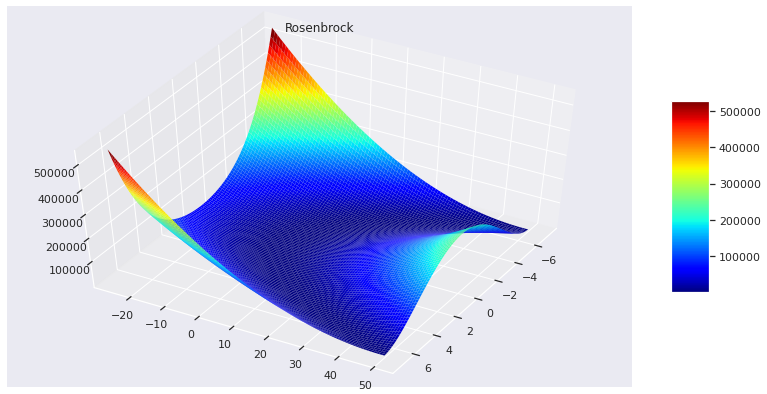

In [0]:
x = np.linspace(-7, 7, 100)
y = np.linspace(-25, 50, 100)
X, Y = np.meshgrid(x, y)
Z = rosenbrock((X, Y))

fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection='3d')
ax.set_title('Rosenbrock')
ax.view_init(elev=50., azim=30)
rosenbrock = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='jet', edgecolor='none')
fig.colorbar(rosenbrock, shrink=0.5, aspect=5)

**Himmelblau's function**

https://en.wikipedia.org/wiki/Himmelblau%27s_function

$f(x,y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2$

The Himmelblau's function has one local maximum at $(x,y) = (-0.270845, -0.923039)$ where $f(x,y)=181.617$, and four identical local minima:

$
f(3.0,2.0)=0 \\
f(-2.805118,3.131312)=0 \\
f(-3.779310,-3.283186)=0 \\ 
f(3.584428,-1.848126)=0
$

In [0]:
def himmelblau(X):
    x, y = X
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

def himmelblau_grad(X):
    x, y = X
    return np.array([
        4 * x * (x**2 + y - 11) + 2 * (x + y**2 - 7),
        2 * (x**2 + y - 11) + 4 * y * (x + y**2 - 7)
    ])

def himmelblau_hess(X):
    x, y = X
    return np.array([
        [2 - 400 * (y - 3 * x**2), -400 * x],
        [-400 * x, 200]
    ])

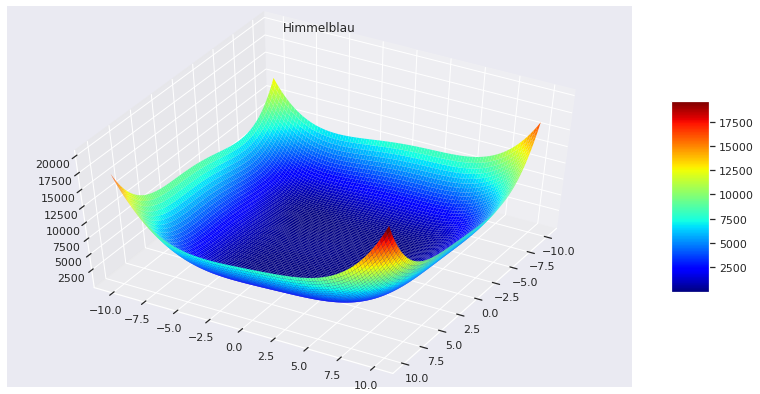

In [0]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = himmelblau((X, Y))

fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection='3d')
ax.set_title('Himmelblau')
ax.view_init(elev=50., azim=30)
himmelblau = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='jet', edgecolor='none')
fig.colorbar(himmelblau, shrink=0.5, aspect=5)

**Easom function**

$f(x,y) = -cos(x)cos(y)exp(-(x-\pi)^2 - (y-\pi)^2)$

$f$ has a global minimum in $(x,y) = (\pi,\pi)$, where $f(\pi, \pi) = -1$.

In [0]:
def easom(X):
    x, y = X
    return -np.cos(x) * np.cos(y) * np.exp(-(x - np.pi)**2 -(y - np.pi)**2)

def easom_grad(X):
    x, y = X
    return np.array([
        np.cos(y) * np.exp(-(x - np.pi)**2 -(y - np.pi)**2) * (np.sin(x) + 2 * np.cos(x)),
        np.cos(x) * np.exp(-(y - np.pi)**2 -(x - np.pi)**2) * (np.sin(y) + 2 * np.cos(y))
    ])

# still have to add the hessian

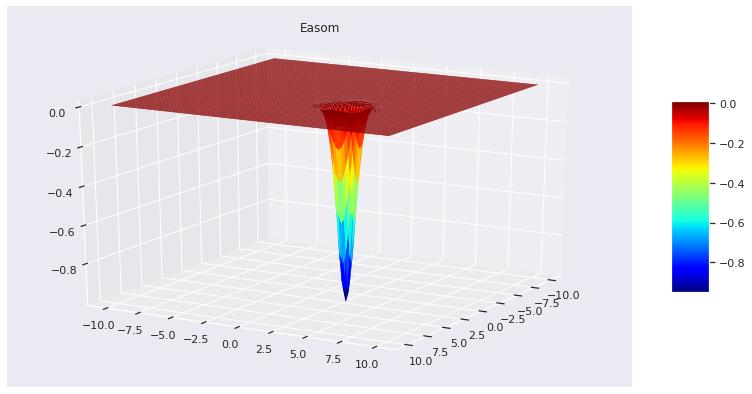

In [0]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = easom((X, Y))

fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection='3d')
ax.set_title('Easom')
ax.view_init(elev=20., azim=30)
s = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='jet', edgecolor='none')
fig.colorbar(s, shrink=0.5, aspect=5)

## **Newton's direction**

$
d = - H_f^{-1}(x) \cdot \nabla_xf(x) \\
H_f(x) = \begin{bmatrix}
\frac{\partial^2 f}{\partial x_1^2} & \cdots & \frac{\partial^2 f}{\partial x_1 \partial x_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial^2 f}{\partial x_n \partial x_1} & \cdots & \frac{\partial^2 f}{\partial x_n^2}
\end{bmatrix}, \quad
\nabla_xf(x) = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}
$


In [0]:
def newton(J_grad, J_hess, x_init, epsilon=1e-10, max_iterations=1000):
    x = x_init
    for i in range(max_iterations):
        x = x - np.linalg.solve(J_hess(x), J_grad(x))
        if np.linalg.norm(J_grad(x)) < epsilon:
            return x, i + 1
    return x, max_iterations

In [0]:
# The Rosenbrock function takes 2 inputs
x_init = np.zeros(2)
x_min, it = newton(rosenbrock_grad, rosenbrock_hess, x_init)
print('x* =', x_min)
print('Rosenbrock(x*) =', rosenbrock(x_min))
print('Grad Rosenbrock(x*) =', rosenbrock_grad(x_min))
print('Iterations =', it)

In [0]:
# The Himmelblau function takes 2 inputs
x_init = np.zeros(2)
x_min, it = newton(himmelblau_grad, himmelblau_hess, x_init, max_iterations=2000)
print('x* =', x_min)
print('Himmelblau(x*) =', himmelblau(x_min))
print('Grad Himmelblau(x*) =', himmelblau_grad(x_min))
print('Iterations =', it)

## **Gradient's direction**

$
d = - \nabla_xf(x) \\
\nabla_xf(x) = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}
$

In [0]:
def gradient_descent(J_grad, x_init, alpha=0.01, epsilon=1e-10, max_iterations=1000):
    x = x_init
    for i in range(max_iterations):
        x = x - alpha * J_grad(x)
        if np.linalg.norm(J_grad(x)) < epsilon:
            return x, i + 1
    return x, max_iterations

In [0]:
# Rosenbrock takes 2 input variables that we set to 0 at first
x_init = np.zeros(2)
x_min, it = gradient_descent(rosenbrock_grad, x_init, alpha=0.002, max_iterations=5000)
print('x* =', x_min)
print('Rosenbrock(x*) =', rosenbrock(x_min))
print('Grad Rosenbrock(x*) =', rosenbrock_grad(x_min))
print('Iterations =', it)

In [0]:
# The Himmelblau function takes 2 inputs
x_init = np.zeros(2)
x_min, it = gradient_descent(himmelblau_grad, x_init)
print('x* =', x_min)
print('Himmelblau(x*) =', himmelblau(x_min))
print('Grad Himmelblau(x*) =', himmelblau_grad(x_min))
print('Iterations =', it)

## **Gradient's direction + Optimal step size**

$
d = - \alpha \nabla_xf(x) \\
\nabla_xf(x) = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}, \quad \alpha \in {\Bbb R}
$

$\alpha$ is the step size, usually in the range $[0,1]$. Unlike the usual gradient descent, here we want to find the optimal $\alpha$ at every iteration. Since at every step, the update is:

$x_{k+1} = x_k - \alpha \nabla_xf(x_k)$

We want to make sure, that the chosen $\alpha$ is going to minimize as much as possible the target function $f$. Therefore, we want $\alpha$ to be such that:

$\alpha_k = \underset{\alpha}{argmin} f(x_k - \alpha \nabla_xf(x_k))$

Since at iteration $k$, $x_k$ and $\nabla_xf(x_k)$ are constants, we can define $q(\alpha)$:

$q(\alpha) = f(x_k - \alpha \nabla_xf(x_k))$

that is a function of one variable, $\alpha$. Therefore, we want to find the right $\alpha$ that will minimize $q$. That task can be solved for instance using gradient descent itself, but since we know that $/alpha$ is bounded, we are going to use another algorithm more suited for this task: Golden Section Search.

https://en.wikipedia.org/wiki/Golden-section_search

In [0]:
def gss(f, a, b, tol=1e-7):
    phi = (np.sqrt(5) + 1) / 2
    d = b - (b - a) / phi
    c = a + (b - a) / phi

    while abs(d - c) > tol:
        if f(d) < f(c):
            b = c
        else:
            a = d

        d = b - (b - a) / phi
        c = a + (b - a) / phi

    return (a + b) / 2

def gradient_descent_optimal(J, J_grad, x_init, epsilon=1e-10, max_iterations=1000):
    x = x_init
    for i in range(max_iterations):
        q = lambda alpha: J(x - alpha * J_grad(x))
        alpha = gss(q, 0, 1)
        x = x - alpha * J_grad(x)
        if np.linalg.norm(J_grad(x)) < epsilon:
            return x, i + 1
    return x, max_iterations

In [0]:
# The Rosenbrock function takes 2 inputs
x_init = np.zeros(2)
x_min, it = gradient_descent_optimal(rosenbrock, rosenbrock_grad, x_init, max_iterations=3000)
print('x* =', x_min)
print('Rosenbrock(x*) =', rosenbrock(x_min))
print('Grad Rosenbrock(x*) =', rosenbrock_grad(x_min))
print('Iterations =', it)

In [0]:
# The Himmelblau function takes 2 inputs
x_init = np.zeros(2)
x_min, it = gradient_descent_optimal(himmelblau, himmelblau_grad, x_init)
print('x* =', x_min)
print('Himmelblau(x*) =', himmelblau(x_min))
print('Grad Himmelblau(x*) =', himmelblau_grad(x_min))
print('Iterations =', it)

# **Optimizer**


* why optimizer
* what is it doing

https://medium.com/explorations-in-language-and-learning/a-short-note-on-gradient-descent-optimization-algorithms-335546c5a896


An overview of gradient descent optimization algorithms

https://arxiv.org/pdf/1609.04747.pdf

**Which Optimizer to use?**

* Wich optimizer should you now use? If your input data is sparse, then you likely achieve the best results using one of the adaptive learning-rate methods. An additional benefit is that you won't need to tune the learning rate but likely achieve the best results with the default value.
* In summary, RMSprop is an extension of Adagrad that deals with its radically diminishing learning rates. It is identical to Adadelta, except that Adadelta uses the RMS of parameter updates in the numinator update rule. Adam, finally, adds bias-correction and momentum to RMSprop. Insofar, RMSprop, Adadelta, and Adam are very similar algorithms that do well in similar circumstances. Kingma et al. [15] show that its bias-correction helps Adam slightly outperform RMSprop towards the end of optimization as gradients become sparser. Insofar, Adam might be the best overall choice.
* Interestingly, many recent papers use vanilla SGD without momentum and a simple learning rate annealing schedule. As has been shown, SGD usually achieves to find a minimum, but it might take significantly longer than with some of the optimizers, is much more reliant on a robust initialization and annealing schedule, and may get stuck in saddle points rather than local minima. Consequently, if you care about fast convergence and train a deep or complex neural network, you should choose one of the adaptive learning rate methods.

**Comparison**

* Few days ago, an interesting paper titled The Marginal Value of Adaptive Gradient Methods in Machine Learning (https://arxiv.org/abs/1705.08292) from UC Berkeley came out. In this paper, the authors compare adaptive optimizer (Adam, RMSprop and AdaGrad) with SGD, observing that SGD has better generalization than adaptive optimizers.
* “We observe that the solutions found by adaptive methods generalize worse (often significantly worse) than SGD, even when these solutions have better training performance. These results suggest that practitioners should reconsider the use of adaptive methods to train neural networks.”
* I was astounded by their finding since I never used SGD before and consider it as an outdated optimizer with slower convergence than Adam or RMSprop. Am I totally wrong from the very beginning?

![Optimizer](https://raw.githubusercontent.com/deltorobarba/repo/master/optimizer_4.png)

https://medium.com/vitalify-asia/whats-up-with-deep-learning-optimizers-since-adam-5c1d862b9db0


## **Types**

**SGD**

(Stochastic Gradient Descent)

* [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) documentation
* Nesterov algorithm based on [this paper](http://jmlr.org/proceedings/papers/v28/sutskever13.pdf)

**Characteristics**
* SGD is a stochastic approximation of the gradient descent optimization and iterative method for minimizing an objective function that is written as a sum of differentiable functions. All other optimizers are called „adaptive“, because they have momentum.
* A compromise between computing the true gradient and the gradient at a single example is to compute the gradient against more than one training example (called a "mini-batch") at each step. This can perform significantly better than "true" stochastic gradient descent described, because the code can make use of vectorization libraries rather than computing each step separately. It may also result in smoother convergence, as the gradient computed at each step uses more training examples.
* The convergence of stochastic gradient descent has been analyzed using the theories of convex minimization and of stochastic approximation. Briefly, when the learning rates decrease with an appropriate rate, and subject to relatively mild assumptions, stochastic gradient descent converges almost surely to a global minimum when the objective function is convex or pseudoconvex, and otherwise converges almost surely to a local minimum.[3][4] This is in fact a consequence of the Robbins-Siegmund theorem.
* SGD suffers from 2 problems: (i) being hesitant at steep slopes, and (ii) having same learning rate for all parameters.

**Formula**

$\theta=\theta-\eta \cdot \nabla_{\theta} J\left(\theta ; x^{(i)} ; y^{(i)}\right)$

* Stochastic gradient descent (SGD) in contrast performs a parameter update for each training example $x^{(i)}$ and label $y^{(i)}$
* Batch gradient descent performs redundant computations for large datasets, as it recomputes gradients for similar examples before each parameter update. SGD does away with this redundancy by performing one update at a time. It is therefore usually much faster and can also be used to learn online. 
* SGD performs frequent updates with a high variance that cause the objective function to fluctuate heavily.

**SGD Optimizer Components**

* **learning_rate**: float hyperparameter >= 0. Learning rate.
* **momentum**: float hyperparameter >= 0 that accelerates SGD in the relevant direction and dampens oscillations.
* **nesterov**: boolean. Whether to apply Nesterov momentum.

**// Extension: SGD with Momentum**

**Characteristics**
* The update vector consists of another term which has the previous update vector (weighted by γ). This helps it to move faster downhill — like a ball.
* The momentum term γ is usually set to 0.9 or a similar value.

**Formula**

$\begin{aligned}
v_{t} &=\gamma v_{t-1}+\eta \nabla_{\theta} J(\theta) \\
\theta &=\theta-v_{t}
\end{aligned}$

![Momentum](https://raw.githubusercontent.com/deltorobarba/repo/master/momentum.png)

Source: [An overview of gradient descent optimization
algorithms](https://arxiv.org/pdf/1609.04747.pdf)

**//SGD with NAG (Nesterov Accelerated Gradient)**

**Characteristics**
* In Momentum optimizer, the ball may go past the minima due to too much momentum, so we want to have a look-ahead term. 
* In NAG, we take gradient of future position instead of current position.

**Formula**

$\begin{aligned}
v_{t} &=\gamma v_{t-1}+\eta \nabla_{\theta} J\left(\theta-\gamma v_{t-1}\right) \\
\theta &=\theta-v_{t}
\end{aligned}$

**Adam** 

(Adaptive Moment Estimation)

* [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) documentation
* Algorithm based on the paper ['Adam: A Method for Stochastic Optimization' by Kingma et al., 2014,](https://arxiv.org/abs/1412.6980)

**Characteristics**
* The theory is that Adam already handles learning rate optimization ([Check paper](http://arxiv.org/pdf/1412.6980v8.pdf)) : "We propose Adam, a method for efficient stochastic optimization that only requires first-order gradients with little memory requirement. The method computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients; the name Adam is derived from adaptive moment estimation."
* Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. The method is computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters.
* Adam can be looked at as a combination of RMSprop and Stochastic Gradient Descent with momentum. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum.

**Formula**

$\theta_{t+1}=\theta_{t}-\frac{\eta}{\sqrt{\hat{v}_{t}+\epsilon}} \hat{m}_{t}$

* Adam combines RMSProp with Momentum. So, in addition to using the decaying average of past squared gradients for parameter-specific learning rate, it uses a decaying average of past gradients in place of the current gradient (similar to Momentum).
* The ^ terms are actually bias-corrected averages to ensure that the values are not biased towards 0.

**Adam Optimizer Components**

* **learning_rate**: A Tensor or a floating point value. The learning rate.
* **beta_1**: A float value or a constant float tensor. The exponential decay rate for the 1st moment estimates.
* **beta_2**: A float value or a constant float tensor. The exponential decay rate for the 2nd moment estimates.
* **epsilon**: A small constant for numerical stability. This epsilon is "epsilon hat" in the Kingma and Ba paper (in the formula just before Section 2.1), not the epsilon in Algorithm 1 of the paper.
* **amsgrad**: boolean. Whether to apply AMSGrad variant of this algorithm from the paper "On the Convergence of Adam and beyond".


**// Extension: Nadam (Nesterov Adaptive Moment Estimation)**

* [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Nadam) documentation
* Algorithm based on the paper ['Incorporating Nesterov Momentum into Adam' by Dozat, T., 2015](http://cs229.stanford.edu/proj2015/054_report.pdf)

**Characteristics**
* Nadam is Adam with Nesterov momentum

**Nadam Optimizer Components**
* learning_rate: A Tensor or a floating point value. The learning rate.
* beta_1: A float value or a constant float tensor. The exponential decay rate for the 1st moment estimates.
* beta_2: A float value or a constant float tensor. The exponential decay rate for the 2nd moment estimates.
* epsilon: A small constant for numerical stability. This epsilon is "epsilon hat" in the Kingma and Ba paper (in the formula just before Section 2.1), not the epsilon in Algorithm 1 of the paper.

**RMSprop**

* [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop) documentation
* RMSprop is an unpublished optimization algorithm designed for neural networks, first proposed by Geoff Hinton in lecture 6 of the online course “Neural Networks for Machine Learning”

**Characteristics**
* RMSPro: works well in non-stationary settings. RMSProp with momentum is the method most closely related to Adam. Main differences: RMSProp rescales gradient and then applies momentum, Adam first applies momentum (moving average) and then rescales. RMSProp lacks bias correction, often leading to large stepsizes in early stages of run (especially when β2 is close to 1)
* maintain a moving (discounted) average of the square of gradients
divide gradient by the root of this average
* This implementation of RMSprop uses plain momentum, not Nesterov momentum.
* The centered version additionally maintains a moving average of the gradients, and uses that average to estimate the variance

**Formula**

$E\left[g^{2}\right]_{t}=\gamma E\left[g^{2}\right]_{t-1}+(1-\gamma) g_{t}^{2}$

* In Adagrad, since we keep adding all gradients, gradients become vanishingly small after some time. So in RMSProp, the idea is to add them in a decaying fashion as shown in the formula. 
* Now replace G_t in the denominator of Adagrad equation by this new term. Due to this, the gradients are no more vanishing.

**RMSprop Optimizer Components**
* **learning_rate**: A Tensor or a floating point value. The learning rate.
* **rho**: Discounting factor for the history/coming gradient
* **momentum**: A scalar tensor.
* **epsilon**: Small value to avoid zero denominator.
* **centered**: If True, gradients are normalized by the estimated variance of the gradient; if False, by the uncentered second moment. Setting this to True may help with training, but is slightly more expensive in terms of computation and memory. Defaults to False.

**Adagrad**

**Characteristics**
* Instead of a common learning rate for all parameters, we want to have separate learning rate for each. So Adagrad keeps sum of squares of parameter-wise gradients and modifies individual learning rates using this. As a result, parameters occuring more often have smaller gradients.
* works well with sparse gradients


**FTRL** 

(Follow The (Proximally) Regularized Leader)

* Algorithm based on [this paper](https://www.eecs.tufts.edu/~dsculley/papers/ad-click-prediction.pdf)
* [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Ftrl) documentation

**Characteristics**
* kkk

**Ftrl Optimizer Components**

* learning_rate: A float value or a constant float Tensor.
learning_rate_power: A float value, must be less or equal to zero. Controls how the learning rate decreases during training. Use zero for a fixed learning rate.
* initial_accumulator_value: The starting value for accumulators. Only zero or positive values are allowed.
* l1_regularization_strength: A float value, must be greater than or equal to zero.
* l2_regularization_strength: A float value, must be greater than or equal to zero.
* l2_shrinkage_regularization_strength: A float value, must be greater than or equal to zero. This differs from L2 above in that the L2 above is a stabilization penalty, whereas this L2 shrinkage is a magnitude penalty. The FTRL formulation can be written as: w_{t+1} = argminw(\hat{g}{1:t}w + L1||w||_1 + L2||w||_2^2), where \hat{g} = g + (2L2_shrinkagew), and g is the gradient of the loss function w.r.t. the weights w. Specifically, in the absence of L1 regularization, it is equivalent to the following update rule: w_{t+1} = w_t - lr_t / (1 + 2L2lr_t) * g_t - 2L2_shrinkagelr_t / (1 + 2L2lr_t) * w_t where lr_t is the learning rate at t. When input is sparse shrinkage will only happen on the active weights.\

## **Run an Example**

**Select one optimizer**

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, 
                                    momentum=0.9, 
                                    nesterov=False)

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, 
                                     beta_1=0.9, 
                                     beta_2=0.999, 
                                     epsilon=1e-07, 
                                     amsgrad=False)

In [0]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01, 
                                      beta_1=0.9, 
                                      beta_2=0.999, 
                                      epsilon=1e-07)

In [0]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, 
                                        rho=0.9, 
                                        momentum=0.0, 
                                        epsilon=1e-07, 
                                        centered=False)

In [0]:
optimizer = tf.keras.optimizers.Ftrl(learning_rate=0.001, 
                                     learning_rate_power=-0.5, 
                                     initial_accumulator_value=0.1, 
                                     l1_regularization_strength=0.0, 
                                     l2_regularization_strength=0.0, 
                                     name='Ftrl', 
                                     l2_shrinkage_regularization_strength=0.0)

In [0]:
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.001, 
                                        rho=0.9, 
                                        epsilon=1e-07)

In [0]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001, 
                                        initial_accumulator_value=0.1,
                                        epsilon=1e-07)

In [0]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.01, 
                                     beta_1=0.9, 
                                     beta_2=0.999, 
                                     epsilon=1e-07)

**Define Model & Run**

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train, 
          y=y_train, 
          epochs=5, 
          validation_data=(x_test, y_test))

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6443 - accuracy: 0.7715 - val_loss: 0.5088 - val_accuracy: 0.8255
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5688 - accuracy: 0.7973 - val_loss: 0.5217 - val_accuracy: 0.8290
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5371 - accuracy: 0.8085 - val_loss: 0.4776 - val_accuracy: 0.8353
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5292 - accuracy: 0.8123 - val_loss: 0.4905 - val_accuracy: 0.8304
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5235 - accuracy: 0.8153 - val_loss: 0.4869 - val_accuracy: 0.8368
